In [3]:
import numpy as np
import math
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
class PDE:
    def __init__(self, xi, tpoints=201, xpoints=512, trange=(0,20), xrange=(-30, 30), seed=0):
        """
        xi is a 2d matrix where each entry corresponds to a coefficient of a term, 
        where the 1st axis corresponds to the order of the space partial derivative
        and the 2nd axis corresponds to the degree of the function.
        For example, ut = 1+2u+3u**2 + 4ux+5uxu+6uxu**2 + 7uxx+8uxxu+9uxxu**2
        becomes [[1, 2, 3],[4, 5, 6],[7, 8, 9]]
        """
        
        self.rng = np.random.RandomState(seed)
        
        self.xi = xi
        self.max_order = self.xi.shape[0]-1 #the minus 1 is because it goes from 0 to max, inclusive
        self.max_degree = self.xi.shape[1]-1 #the minus 1 is because it goes from 0 to max, inclusive
        
        self.tpoints = tpoints
        self.xpoints = xpoints
        self.trange = trange
        self.xrange = xrange
        
        self.dt = (self.trange[1]-self.trange[0])/ self.tpoints #time steps
        self.dx = (self.xrange[1]-self.xrange[0])/ self.xpoints #space step
        
        self.u = self.init_u()
        self.simulated = False
        
    def init_u(self):
        #makes one wavelength of cos, from 1 crest to the next
        xarr = np.linspace(self.xrange[0], self.xrange[1], self.xpoints)
        k = 2*np.pi/(self.xrange[1] - self.xrange[0])
        phi = np.pi
        u0 = np.cos(k*xarr+phi)
        uempty = np.full((self.xpoints,), np.nan, dtype=float)
        return np.vstack([u0]+[uempty]*(self.tpoints-1))
    
    def __repr__(self):
        rep = 'ut ='
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                if coef == 0:
                    term = ''
                else:
                    #coefficient factor
                    if coef > 0:
                        term = ' + ' + str(coef)
                    elif coef < 0:
                        term = ' - ' + str(-coef)
                    #partial deriv factor
                    if order > 0:
                        term += 'u' + 'x'*order
                    else: 
                        pass
                    #function factor
                    if degree == 1:
                        term += 'u'
                    elif degree > 1:
                        term += 'u**'+degree
                    else: 
                        pass
                rep += term
        if rep == 'ut =':
            rep = 'ut = 0'
        rep += '\n\twith xpoints='+str(self.xpoints)+' in '+str(self.xrange)
        rep += '\n\tand with tpoints='+str(self.tpoints)+' in '+str(self.trange)
        return rep
        
        
    def get_dxs(self, point, npoints_behind, npoints_ahead):
        diffs_behind = list(self.dxs[point-npoints_behind:point])
        diffs_ahead = list(self.dxs[point:point+npoints_ahead])
        return diffs_behind + diffs_ahead
    
    def get_du_x(self, time, point):
        ugrid = self.u[time]
        if point+1 >= ugrid.shape[0]:
               raise IndexError("Index too large")
        elif point < 0:
            raise IndexError("Index too small")
        else:
            return ugrid[point+1] - ugrid[point]
    def get_du_x_middle(self, time, point):
        ugrid = self.u[time]
        if point+1 >= ugrid.shape[0]:
               raise IndexError("Index too large")
        elif point-1 < 0:
            raise IndexError("Index too small")
        else:
            return ugrid[point+1] - ugrid[point-1]
    
    def get_x_deriv_forward(self, time, point, order):
        if order == 0:
            return self.get_du_x(time, point)
        else:
            return (self.get_x_deriv(time, point+1, order-1)-self.get_x_deriv(time, point, order-1))/self.dx
    def get_x_deriv_backward(self, time, point, order):
        if order == 0:
            return self.get_du_x(time, point-1)
        else:
            return (self.get_x_deriv(time, point, order-1)-self.get_x_deriv(time, point-1, order-1))/self.dx
    def get_x_deriv_middle(self, time, point, order, verbose=False):
        if order == 0:
            ugrid = self.u[time]
            return self.get_du_x_middle(time, point)/(2*self.dx)
        else: 
            return (self.get_x_deriv(time, point+1, order-1)-self.get_x_deriv(time, point-1, order-1))/(2*self.dx)
    def get_x_deriv(self, time, point, order):
        try:
            deriv = self.get_x_deriv_middle(time, point, order)
        except IndexError:
            try:
                deriv = self.get_x_deriv_forward(time, point, order)
            except IndexError:
                deriv = self.get_x_deriv_backward(time, point, order)
        return deriv
    def get_t_deriv(self, time, point):
        deriv = 0
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                xderiv = self.get_x_deriv(time, point, order)
                u = self.u[time, point]
                try: 
                    deriv += coef * u**degree * xderiv
                except FloatingPointError:
                    print("time = "+str(time))
                    print("coef = "+str(coef))
                    print("u = "+str(u))
                    print("u**"+str(degree)+" = "+str(u**degree))
                    print("ux = "+str(xderiv))
                    raise
        return deriv
    
    def sim_next_point(self, time, point):
        u_curr = self.u[time, point]
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                u_next = u_curr + self.dt*self.get_t_deriv(time, point)
        return u_next
    def sim_next_grid(self, time):
        next_grid = np.empty((self.xpoints,), dtype=float)
        for point in range(self.xpoints):
            next_grid[point] = self.sim_next_point(time, point)
        return next_grid
    def sim(self, force=False):
        if self.simulated == False or force == True:
            if force == True: print("Resimulating PDE from first step")
            for time in range(self.tpoints-1):
                self.u[time+1] = self.sim_next_grid(time)
            self.simulated == True
            return self.u
        else:
            print("PDE already simulated")
            return self.u

In [48]:
xi = np.zeros((1, 2))
xi[0, 1] = 1
pde = PDE(xi, xrange=(-np.pi, np.pi))
print(pde)

ut = + 1.0u
	with xpoints=512 in (-3.141592653589793, 3.141592653589793)
	and with tpoints=201 in (0, 20)


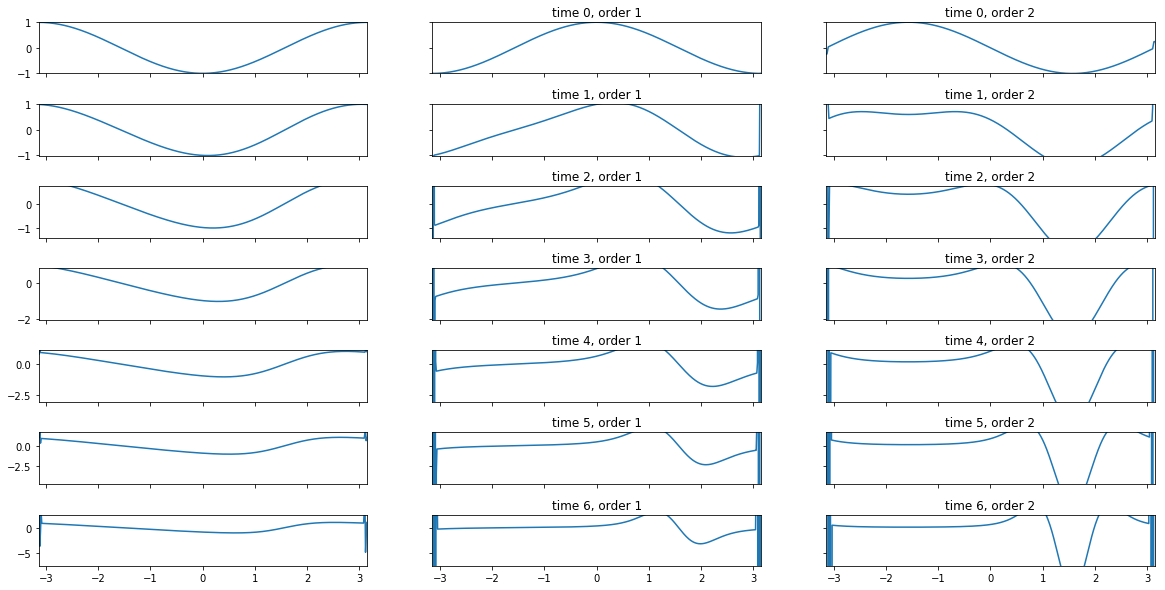

In [53]:
#print(pde.get_x_deriv_middle(0, 512//4, 1, verbose=True))
max_time = 7

fig, axes = plt.subplots(nrows=max_time, ncols=3, figsize=(20,10), sharex='all', sharey='row')
x = np.linspace(pde.xrange[0], pde.xrange[1], pde.xpoints)

for time in range(max_time):
    y0 = pde.u[time]
    axes[time, 0].plot(x, y0)
    #ylims = axes[time, 0].get_ylim()
    for order in range(1, 3):
        y = [pde.get_x_deriv(time, point, order) for point in range(pde.xpoints)]
        axes[time, order].plot(x, y)
        axes[time, order].set(title='time '+str(time)+', order '+str(order))
    axes[time, 0].set_xlim(pde.xrange[0], pde.xrange[1])
    axes[time, 0].set_ylim(ymin, ymax)
    pde.u[time+1] = pde.sim_next_grid(time)
    ymin = np.min(y[int(pde.xpoints*0.10):int(pde.xpoints*0.90)])
    ymax = np.max(y[int(pde.xpoints*0.10):int(pde.xpoints*0.90)])
plt.subplots_adjust(hspace=0.6)
plt.show()

0: u = 1.0
1: u = 1.5455112357161447
2: u = 3222.3532857372925
3: u = -12570512125478.11
4: u = 2.5194061749971256e+32
5: u = -7.583043645430753e+70
6: u = 6.948932247832748e+147
7: u = -5.790382470904478e+301
time = 7
coef = -6.0
u = -5.790382470904478e+301
u**1 = -5.790382470904478e+301
ux = 1.1698577897443885e+308


FloatingPointError: overflow encountered in double_scalars

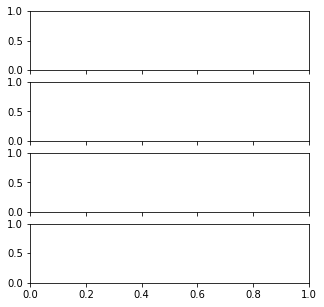

In [54]:
np.seterr(all='raise')
np.seterr(under='ignore')

fig, axes = plt.subplots(kdv.max_order+1, figsize=(5,5), sharex=True, sharey=True)

for time in range(kdv.tpoints-1):
    
    print(str(time)+": u = "+str(kdv.u[time, 0]))
    kdv.u[time+1] = kdv.sim_next_grid(time)
    if np.any(np.isnan(kdv.u[time+1])):
        print(kdv.u[time+1])

### TO DO
- rewrite get_x_deriv and it's forward/backward/middle versions to have less nested steps
- expand possible equations to include more non-linearity, like ut = sin(ux)
- make it possible to have an irregular grid spacing
- add boundary conditions